In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

## Exploratory data analysis

In [2]:
data = pd.read_csv('english_news.csv', sep='\t')

In [3]:
data.head()

,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...


The problem is that the author and the text are not clearly separated and there isn't a repetead pattern that can bee useful to identify the author.


In [4]:
def extract_author_text(combined_str):
    combined_str = str(combined_str)
    
    match = re.match(r'^(?P<author>([A-Z][a-z]+(?: [A-Z][a-z]+)+|[A-Z]+(?: [A-Z]+)+)?)(?P<text>.*)', combined_str, re.DOTALL)
    if match and match.group('author'):
        return match.group('author').strip(), match.group('text').strip()
    else:
        return "", combined_str.strip()
    
# data['text'] = data['text'].fillna('')
data['author'], data['text'] = zip(*data['text'].apply(extract_author_text))

In [5]:
data.head()

,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",The Japanese,"government is trying to boost the uptake of ""M..."
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,Prime Minister Fumio Kishida,", who won a public mandate for his administrat..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,,The U.S. administration under President Joe Bi...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36889 entries, 0 to 36888
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  36889 non-null  object
 1   date    36889 non-null  object
 2   title   36889 non-null  object
 3   author  36889 non-null  object
 4   text    36889 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [7]:
data.isna().sum()

source    0
date      0
title     0
author    0
text      0
dtype: int64

In [8]:
data.isnull().mean() * 100

source    0.0
date      0.0
title     0.0
author    0.0
text      0.0
dtype: float64

In [9]:
data['author'].nunique()

3695

## Preprocessing and feature engineering

In [10]:
# extraction of year month day in order to use them in the model after scaling
data['year'] = pd.to_datetime(data['date']).dt.year
data['month'] = pd.to_datetime(data['date']).dt.month
data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek

In [11]:
# scaling temporal data
scaler = MinMaxScaler()
data['year_scaled'] = scaler.fit_transform(data[['year']])
data['month_scaled'] = scaler.fit_transform(data[['month']])
data['day_of_week_scaled'] = scaler.fit_transform(data[['day_of_week']])

In [12]:
data

,source,date,title,author,text,year,month,day_of_week,year_scaled,month_scaled,day_of_week_scaled
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",The Japanese,"government is trying to boost the uptake of ""M...",2021,12,0,1.0,1.000000,0.000000
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,Prime Minister Fumio Kishida,", who won a public mandate for his administrat...",2021,12,1,1.0,1.000000,0.166667
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",,It has been 80 years since the start of the Pa...,2021,12,2,1.0,1.000000,0.333333
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",,"""The world has changed completely. The era was...",2021,12,2,1.0,1.000000,0.333333
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,,The U.S. administration under President Joe Bi...,2021,12,2,1.0,1.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...
36884,The Japan Times,2021-06-06,COVID-19 tracker: Tokyo reports 351 new cases ...,,Tokyo confirmed 351 new cases of COVID-19 on S...,2021,6,6,1.0,0.454545,1.000000
36885,The Japan Times,2021-06-07,Dollar weakens to around ¥109.40 in Tokyo,,The dollar eased to around ¥109.40 in Tokyo tr...,2021,6,0,1.0,0.454545,0.000000
36886,The Japan Times,2021-06-07,"Nikkei ends higher, but gains limited",,The benchmark Nikkei average turned higher on ...,2021,6,0,1.0,0.454545,0.000000
36887,The Japan Times,2021-06-07,COVID-19 tracker: Osaka reports 72 new cases b...,Osaka Prefecture,"reported 72 new COVID-19 cases on Monday, fall...",2021,6,0,1.0,0.454545,0.000000


In [13]:
# vectorizing text column
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_tfidf = vectorizer.fit_transform(data['text'])

text_features = [f"text_{name}" for name in vectorizer.get_feature_names_out()]
text_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=text_features, index=data.index)

text_tfidf_df.index = data.index

# vectorizing author column
data['author'] = data['author'].astype(str)
vectorizer = TfidfVectorizer()
author_tfidf = vectorizer.fit_transform(data['author'])

author_features = [f"author_{name}" for name in vectorizer.get_feature_names_out()]
author_tfidf_df = pd.DataFrame(author_tfidf.toarray(), columns=author_features, index=data.index)

author_tfidf_df.index = data.index

final_df = pd.concat([data[['year_scaled', 'month_scaled', 'day_of_week_scaled']], author_tfidf_df, text_tfidf_df], axis=1)

In [14]:
final_df.head()

,year_scaled,month_scaled,day_of_week_scaled,author_aaron,author_ab,author_ababa,author_abbas,author_abdul,author_abe,author_abel,...,text_zen,text_zero,text_zhu,text_zico,text_zimbabwe,text_zoellick,text_zone,text_zones,text_zoo,text_zurich
0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Models

I modelli che seguono sono stati scelti in seguito alla decisione di utilizzare le feature temporali in maniera diretta (senza l'utilizzo di one hot encoding ad esempio) per evitare la creazione di numerose nuove colonne oltre a quelle già create per la trasformazione delle colonne text e author

In [15]:
X = final_df  
y = data['source']

# converting the target in 0,1
y = y.map({'Mainichi Shimbun':0, 'The Japan Times':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# check if the categorical transformation is correct
y.unique()

array([0, 1])

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf}')

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9998644619137977
Random Forest
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      1.00      1.00      7366

    accuracy                           1.00      7378
   macro avg       1.00      0.96      0.98      7378
weighted avg       1.00      1.00      1.00      7378



## Alternative preprocessing: PCA

In [23]:
n_components = 7000  


scaler = StandardScaler()
pca = PCA(n_components=n_components)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

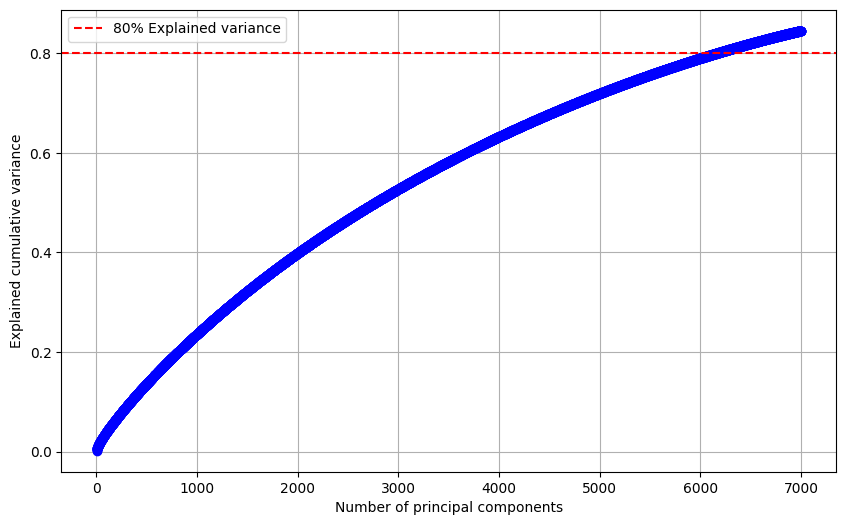

In [26]:
explained_cum_var = np.cumsum(pca.explained_variance_ratio_)

n_components_array = np.arange(len(explained_cum_var)) + 1

plt.figure(figsize=(10, 6))
plt.plot(n_components_array, explained_cum_var, marker='o', linestyle='-', color='b')

plt.xlabel('Number of principal components')
plt.ylabel('Explained cumulative variance')

plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained variance')
plt.legend(loc='best')

plt.grid(True)
plt.show()


### Random forest with pca

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

y_pred_rf = rf_model.predict(X_test_pca)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf}')

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9983735429655733
Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      1.00      1.00      7366

    accuracy                           1.00      7378
   macro avg       0.50      0.50      0.50      7378
weighted avg       1.00      1.00      1.00      7378



/Users/Chiara/anaconda3/envs/dproject_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Chiara/anaconda3/envs/dproject_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Chiara/anaconda3/envs/dproject_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Logistic regression without pca

In [29]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr}')

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.9994578476551911
Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       1.00      1.00      1.00      7366

    accuracy                           1.00      7378
   macro avg       1.00      0.83      0.90      7378
weighted avg       1.00      1.00      1.00      7378



### Logistic regression with pca

In [30]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_pca, y_train)

y_pred_lr = lr_model.predict(X_test_pca)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr}')

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.9990512333965844
Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       1.00      1.00      1.00      7366

    accuracy                           1.00      7378
   macro avg       0.93      0.75      0.82      7378
weighted avg       1.00      1.00      1.00      7378



In this case, PCA was more important for reducing computation time than for improving accuracy.

### SVC with pca

In [31]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_pca, y_train)

y_pred_svm = svm_model.predict(X_test_pca)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy_svm}')

print("Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.9995933857413933
Support Vector Machine
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       1.00      1.00      1.00      7366

    accuracy                           1.00      7378
   macro avg       1.00      0.88      0.93      7378
weighted avg       1.00      1.00      1.00      7378



### SCV without pca

In [32]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy_svm}')

print("Support Vector Machine")
print(classification_report(y_test, y_pred_svm))

Accuracy: 1.0
Support Vector Machine
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00      7366

    accuracy                           1.00      7378
   macro avg       1.00      1.00      1.00      7378
weighted avg       1.00      1.00      1.00      7378

